# Cluster level integration (matching up clusters with correlation)

In [2]:
from __init__ import *
import seaborn as sns 
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted

import snmcseq_utils
# import CEMBA_update_mysql

In [55]:
def compute_logtpm(df, lengths):
    """
    Args:
        - df: a dataframe
        - lengths: a series
    """
    res = df.divide(lengths, axis=0)
    res = res.divide(res.sum(axis=0), axis=1)
    res = np.log10(res*1e6+1)
    return res

In [3]:
# snmc-tsne-clustering-data
# snatac-tsne-clustering-data
# snrna-tsne-clustering-data

In [4]:
# get cluster wise feature for each modality

In [5]:
# select features in common

In [6]:
# do all-to-all correlations

In [7]:
# select subset of cell types and look at correlations

# references (gene_annotation)

In [4]:
df_genes = pd.read_table(
    os.path.join(PATH_REFERENCES, 'Annotation', 'gencode.v19.annotation_genes.tsv'), index_col='gene_id')
df_genes.head()

,gene_name,chr,start,end,strand,gene_type
gene_id,,,,,,
ENSG00000223972.4,DDX11L1,chr1,11869,14412,+,pseudogene
ENSG00000227232.4,WASH7P,chr1,14363,29806,-,pseudogene
ENSG00000243485.2,MIR1302-11,chr1,29554,31109,+,lincRNA
ENSG00000237613.2,FAM138A,chr1,34554,36081,-,lincRNA
ENSG00000268020.2,OR4G4P,chr1,52473,54936,+,pseudogene


# ATAC preprocessing

In [135]:
# atac data
fs = natsorted(glob.glob(
    '/cndd/Public_Datasets/human_snatacseq/clusters/umb4540_snatacseq_L3_C*.uniq_readends_sort_counts_dmr_3dms.bed'))
clusters = [int(os.path.basename(f).replace('.', '_').split('_')[3].strip('C')) for f in fs]

for i, (clst, f) in enumerate(zip(clusters, fs)):
    df_load = pd.read_table(f, header=None, names=['chr', 'start', 'end', 'ndms', 'count'], 
                           dtype={'chr': object})
    if i == 0:
        df_atac = pd.DataFrame()
        df_atac['chr'] = df_load['chr']
        df_atac['start'] = df_load['start']
        df_atac['end'] = df_load['end']
        
    df_atac[clst] = df_load['count']
    
print(df_atac.shape)
df_atac.head()


(740738, 22)


,chr,start,end,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,1,13416,13537,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,231417,231735,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,2
2,1,235695,236127,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,540604,540991,0,0,0,0,0,0,0,...,0,0,4,0,0,0,3,0,0,0
4,1,665017,665077,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# compute logtpm

lengths = df_atac['end'] - df_atac['start']
clusters_atac = compute_logtpm(df_atac.filter(regex='^[0-9]'), lengths)
print(clusters_atac.shape)
clusters_atac[['chr', 'start', 'end']] = df_atac[['chr', 'start', 'end']]
clusters_atac.head()

(740738, 19)


,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,chr,start,end
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,13416,13537
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.907177,0.0,0.0,0.000000,0.0,0.0,0.928067,1,231417,231735
2,0.0,0.0,0.0,0.0,0.658272,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,235695,236127
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.698277,0.0,0.0,0.000000,1,540604,540991
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,665017,665077


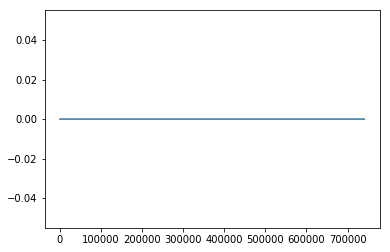

(740738, 22)


,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,chr,start,end
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,13416,13537
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.907177,0.0,0.0,0.000000,0.0,0.0,0.928067,1,231417,231735
2,0.0,0.0,0.0,0.0,0.658272,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,235695,236127
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.698277,0.0,0.0,0.000000,1,540604,540991
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,665017,665077


In [137]:
# remove/impute nan values

plt.plot(clusters_atac.isnull().sum(axis=1).sort_values().values)
plt.show()

clusters_atac = clusters_atac[clusters_atac.isnull().sum(axis=1)==0]
print(clusters_atac.shape)
clusters_atac.head()

# MC preprocessing

In [131]:
# all dmr info (1-based)
ens = 'Ens0'
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_mCH_npc50_k30_merged_rms_results_collapsed.tsv')
df_mcc_raw = pd.read_table(f, 
                       dtype={'#chr': object}).rename(columns={'#chr': 'chr'})
# to 0-based
df_mcc_raw['start'] = df_mcc_raw['start'] - 1

# dmr bed file (0-based)
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_mCH_npc50_k30_merged_rms_results_collapsed.tsv.DMR.3DMS.bed')
df_mcc_bed = pd.read_table(f, header=None, 
                       dtype={'chr': object},
                       names=['chr', 'start', 'end', 'ndms'])

# get dmr info only from dmr bed file
clusters_mcc = pd.merge(df_mcc_raw, df_mcc_bed, on=['chr', 'start', 'end'])
clusters_mcc = clusters_mcc.drop(['number_of_dms', 'hypermethylated_samples', 'hypomethylated_samples', 'ndms'], axis=1)
clusters_mcc.columns = [int(col[len('methylation_level_merged_mCG_mCH_npc50_k30_merged_'):-len('_Ens0_mergestrands')])
    if col not in ['chr', 'start', 'end'] else col for col in clusters_mcc.columns]
# clusters_mcc = clusters_mcc.filter(regex="^methylation_level_*")
print(clusters_mcc.shape)
clusters_mcc.head()

(740738, 20)


,chr,start,end,10,11,14,15,1,2,33,34,35,36,37,38,39,3,4,6,9
0,1,13416,13537,0.650000,0.482072,0.691824,0.944444,0.943396,0.871176,0.880000,0.934426,0.773723,0.664740,0.916667,0.936455,0.798283,0.958678,0.922764,0.887097,0.615686
1,1,231417,231735,0.566667,0.625000,0.666667,0.136364,0.068966,0.200000,0.973684,0.870968,0.875000,0.920000,0.034483,0.250000,0.821429,0.707317,0.181818,0.176471,0.750000
2,1,235695,236127,0.640845,0.583333,0.517857,0.914530,0.752717,0.332574,0.847291,0.841584,0.756364,0.696581,0.839869,0.927536,0.862832,0.800000,0.578199,0.821656,0.687831
3,1,540604,540991,0.000000,0.372727,0.161972,0.000000,0.011125,0.036842,0.361775,0.405109,0.334764,0.309677,0.025526,0.007080,0.036145,0.005602,0.009697,0.001938,0.468278
4,1,665017,665077,0.875000,0.822785,1.000000,1.000000,0.986842,0.972222,0.989474,0.979592,0.962617,0.978261,0.773913,0.989130,1.000000,0.942857,0.972973,1.000000,0.883495


In [132]:
# get mc clusters and name clusters properly

f = '/cndd/Public_Datasets/human_snmcseq/Ensembles/Ens0/Ens0_merged.tsv'
df_info_mc = pd.read_table(f, index_col='cell_name')
df_info_mc.head()

df_clst_annot_mc = df_info_mc[
    ['cluster', 'annotation']].groupby('cluster').first().fillna('hGlia')
print(df_clst_annot_mc.shape)
df_clst_annot_mc.head()



(17, 1)


,annotation
cluster,
1,hL2/3
2,hL2/3
3,hDL-1
4,hL2/3
6,hL5-4


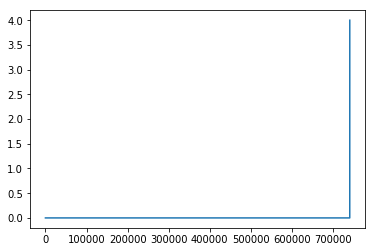

(740676, 20)


,chr,start,end,10,11,14,15,1,2,33,34,35,36,37,38,39,3,4,6,9
0,1,13416,13537,0.650000,0.482072,0.691824,0.944444,0.943396,0.871176,0.880000,0.934426,0.773723,0.664740,0.916667,0.936455,0.798283,0.958678,0.922764,0.887097,0.615686
1,1,231417,231735,0.566667,0.625000,0.666667,0.136364,0.068966,0.200000,0.973684,0.870968,0.875000,0.920000,0.034483,0.250000,0.821429,0.707317,0.181818,0.176471,0.750000
2,1,235695,236127,0.640845,0.583333,0.517857,0.914530,0.752717,0.332574,0.847291,0.841584,0.756364,0.696581,0.839869,0.927536,0.862832,0.800000,0.578199,0.821656,0.687831
3,1,540604,540991,0.000000,0.372727,0.161972,0.000000,0.011125,0.036842,0.361775,0.405109,0.334764,0.309677,0.025526,0.007080,0.036145,0.005602,0.009697,0.001938,0.468278
4,1,665017,665077,0.875000,0.822785,1.000000,1.000000,0.986842,0.972222,0.989474,0.979592,0.962617,0.978261,0.773913,0.989130,1.000000,0.942857,0.972973,1.000000,0.883495


In [133]:
# remove/impute nan values

plt.plot(clusters_mcc.isnull().sum(axis=1).sort_values().values)
plt.show()

clusters_mcc = clusters_mcc[clusters_mcc.isnull().sum(axis=1)==0]

print(clusters_mcc.shape)
clusters_mcc.head()

## common index

In [138]:
# 
region_list = pd.merge(clusters_atac[['chr', 'start', 'end']], clusters_mcc[['chr','start', 'end']], 
         how='inner', on=['chr', 'start', 'end']).set_index(['chr', 'start', 'end']).index

clusters_mcc = clusters_mcc.set_index(['chr', 'start', 'end']).loc[region_list, :]
clusters_atac = clusters_atac.set_index(['chr', 'start', 'end']).loc[region_list, :]

# rename mcc
clusters_mcc.columns = [str(col) + '_' + df_clst_annot_mc.loc[col, 'annotation'] 
  for col in clusters_mcc.columns]
print(clusters_mcc.shape)
print(clusters_atac.shape)

(740676, 17)
(740676, 19)


## correlate

In [224]:

common_features = clusters_atac.index.intersection(clusters_mcc.index)
top_features_atac = clusters_atac.std(axis=1).sort_values(ascending=False).head(100000)
top_features_mcc = clusters_mcc.std(axis=1).sort_values(ascending=False).head(100000)
features = top_features_atac.index.intersection(top_features_mcc.index)
print(len(features))

# features = common_features

data_atac = clusters_atac.rank(pct=True).loc[features, :]
data_mcc = clusters_mcc.rank(pct=True).loc[features, :]

nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]

print(data_atac.shape)
print(data_mcc.shape)



34961
(34961, 19)
(34961, 17)


In [225]:
corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
print(corr.shape)

(36, 36)


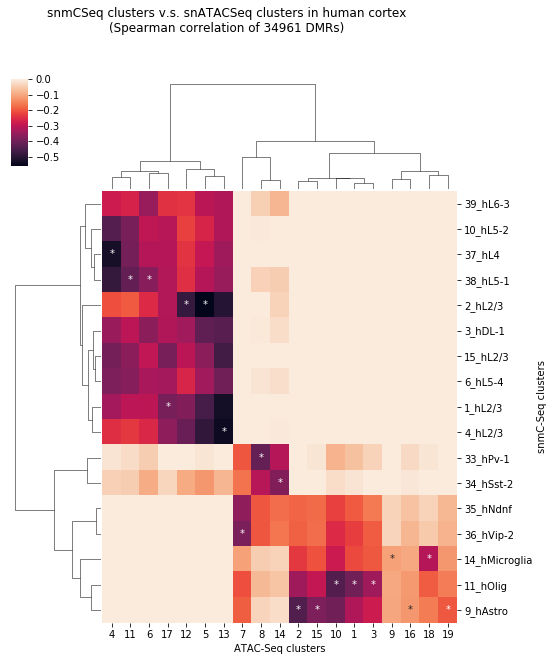

In [226]:
df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
reject_threshold = 100 

df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
for col, idx in df_corr.idxmin().iteritems():
    if df_corr.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot.loc[idx, col] = '*'
    else:
        pass
df_annot = df_annot.fillna('')

# df_annot
g = sns.clustermap(df_corr, 
                   xticklabels=True,
                   yticklabels=True,
                  )
col_orders = []
for label in g.ax_heatmap.get_xticklabels():
    try:
        col_orders.append(int(label.get_text()))
    except:
        col_orders.append(label.get_text())
        
row_orders = []
for label in g.ax_heatmap.get_yticklabels():
    try:
        row_orders.append(int(label.get_text()))
    except:
        row_orders.append(label.get_text())
        
plt.close()
df_annot = df_annot.reindex(row_orders, col_orders)



g = sns.clustermap(df_corr, 
#                    cmap='Purples', 
                   annot=df_annot, fmt='',
#                    xticklabels=True,
#                    yticklabels=True,
                   vmax=0,
                   figsize=(8,10)
                  )
g.ax_heatmap.set_xlabel('ATAC-Seq clusters')
g.ax_heatmap.set_ylabel('snmC-Seq clusters')

g.fig.suptitle("snmCSeq clusters v.s. snATACSeq clusters in human cortex\n"
         + "(Spearman correlation of {} DMRs)".format(len(features)))
g.savefig('/cndd/fangming/integration/correlation_snmcseq_vs_snatacseq_{}DMRs.pdf'.format(len(features)))
plt.show()

In [210]:
common_features = clusters_atac.index.intersection(clusters_mcc.index)
N = 100000
n = 50
reject_threshold = 0

matches = []
for i in range(n): 
    print('.', end='')
    features = common_features.values[np.random.choice(len(common_features), size=N, replace=False)]

    data_atac = clusters_atac.rank(pct=True).loc[features, :]
    data_mcc = clusters_mcc.rank(pct=True).loc[features, :]

    nclst_atac = data_atac.shape[1]
    nclst_mcc = data_mcc.shape[1]

    corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
    
    df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
    # best match for each atac cluster
    for col, idx in df_corr.idxmin().iteritems():
        if df_corr.loc[idx, col] < reject_threshold:
            # print(col + ' --> ' + idx)
            matches.append({'atac': col, 
                            'mc': idx}) # atac, mc
        else:
            pass
    # best match for each mc cluster
    for col, idx in df_corr.T.idxmin().iteritems():
        if df_corr.T.loc[idx, col] < reject_threshold:
            # print(col + ' --> ' + idx)
            matches.append({'atac': idx, 
                            'mc': col}) # atac, mc
        else:
            pass
matches = pd.DataFrame(matches)

..................................................

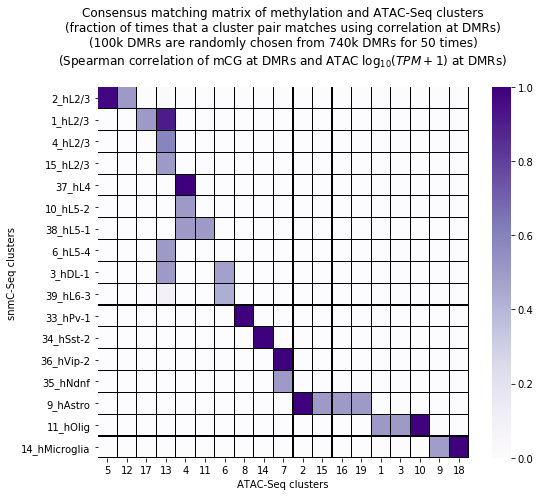

In [214]:
atac_orders = [5, 12, 17, 13, 4, 11, 6, 8, 14, 7, 2, 15, 16, 19, 1, 3, 10, 9, 18]
mc_orders = [2, 1, 4, 15, 37, 10, 38, 6, 3, 39, 33, 34, 36, 35, 9, 11, 14]
mc_orders = [str(item) + '_' + df_clst_annot_mc.loc[item, 'annotation'] 
                 for item in mc_orders]

coclst = (matches.groupby(['atac', 'mc']).size().to_frame('num').reset_index()
          .pivot(index='atac', columns='mc', values='num').fillna(0)/(2*n))
coclst = coclst.reindex(atac_orders, mc_orders).T.fillna(0)

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(coclst, 
            cmap='Purples',
            ax=ax,
            linewidths=0.1, 
            linecolor='black', 
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('ATAC-Seq clusters')
ax.set_ylabel('snmC-Seq clusters')
ax.set_title("""Consensus matching matrix of methylation and ATAC-Seq clusters
(fraction of times that a cluster pair matches using correlation at DMRs)
(100k DMRs are randomly chosen from 740k DMRs for 50 times)
(Spearman correlation of mCG at DMRs and ATAC $\log_{10}(TPM+1)$ at DMRs) 
""")
fig.tight_layout()
fig.savefig("/cndd/Public_Datasets/human_snatacseq/clusters/results/consensus_matching_matrix_dmr.pdf")
plt.show()